<a href="https://colab.research.google.com/github/rashidrao-pk/DL2022/blob/main/Copy_of_DL2223_Text_Classification_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Download data: AbusEval (https://github.com/tommasoc80/AbuseEval)
!wget -c https://datacloud.di.unito.it/index.php/s/jc6xY3cGDgMcdpY/download/train.csv
!wget -c https://datacloud.di.unito.it/index.php/s/LHfgiHipMy95nQr/download/dev.csv
!wget -c https://datacloud.di.unito.it/index.php/s/oqAWsFmZMegMzHG/download/test.csv

--2023-02-21 15:24:00--  https://datacloud.di.unito.it/index.php/s/jc6xY3cGDgMcdpY/download/train.csv
Resolving datacloud.di.unito.it (datacloud.di.unito.it)... 130.192.156.25
Connecting to datacloud.di.unito.it (datacloud.di.unito.it)|130.192.156.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598506 (1.5M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>]   1.52M  1.35MB/s    in 1.1s    

2023-02-21 15:24:01 (1.35 MB/s) - ‘train.csv’ saved [1598506/1598506]

--2023-02-21 15:24:01--  https://datacloud.di.unito.it/index.php/s/LHfgiHipMy95nQr/download/dev.csv
Resolving datacloud.di.unito.it (datacloud.di.unito.it)... 130.192.156.25
Connecting to datacloud.di.unito.it (datacloud.di.unito.it)|130.192.156.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226062 (221K) [text/csv]
Saving to: ‘dev.csv’

dev.csv             100%[===================>] 220.76K  1.18MB/s    in 0.2s    

2023-02-21 15:24:02 (1

In [2]:
#!title Download SpaCy model for English
import locale
import spacy
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
locale.getpreferredencoding()
!python -m spacy download en_core_web_sm

2023-02-21 15:26:21.309442: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-21 15:26:21.309567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-21 15:26:21.309587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.5 MB/s

In [3]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title Functions for text preprocessing
import spacy
import csv
import preprocessor as tp
from tqdm import tqdm

tp.set_options(tp.OPT.URL, tp.OPT.EMOJI, tp.OPT.HASHTAG, tp.OPT.MENTION)

nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "pos"])

def preprocess_text(text):
    text = tp.clean(text)
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if (not token.is_stop)]
    return tokens

def preprocess_csv(filename):
    sentences = []
    ids = []
    labels = []
    with open(filename, encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in tqdm(reader):
            sentences.append(preprocess_text(row["text"]))
            ids.append(row["id"])
            labels.append(eval(row["label"]))
    return sentences, ids, labels

In [5]:
sentences_train, ids_train, labels_train = preprocess_csv("train.csv")
sentences_dev, ids_dev, labels_dev = preprocess_csv("dev.csv")
sentences_test, ids_test, labels_test = preprocess_csv("test.csv")

0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
11585it [01:31, 127.09it/s]
1655it [00:12, 127.89it/s]
860it [00:06, 134.10it/s]


In [6]:
print (sentences_train[0])

['established', 'war', 'living', '.', 's', 'nt', 'happening']


In [7]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np

tokenizer = Tokenizer(filters='', lower=True, split=' ')
tokenizer.fit_on_texts(sentences_train)
word_index = tokenizer.word_index

X_train = pad_sequences(tokenizer.texts_to_sequences(sentences_train), 50)
y_train = np.array(labels_train)
X_dev = pad_sequences(tokenizer.texts_to_sequences(sentences_dev), 50)
y_dev = np.array(labels_dev)
X_test = pad_sequences(tokenizer.texts_to_sequences(sentences_test), 50)
y_test = np.array(labels_test)

In [8]:
print (X_train.shape)
print (y_train.shape)

(11585, 50)
(11585,)


In [12]:
#@title Build the model
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM

model = Sequential()
model.add(Embedding(
        len(word_index)+1, 
        100, 
        input_shape=(50,)))
model.add(LSTM(8))
model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(2, activation='sigmoid'))

In [13]:
from keras.optimizers import adam_v2

opt = adam_v2.Adam(learning_rate=1e-4)
model.summary()
model.compile(loss='binary_crossentropy',
                    optimizer=opt,
                    metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           1683900   
                                                                 
 lstm_2 (LSTM)               (None, 8)                 3488      
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,687,397
Trainable params: 1,687,397
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=5,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_dev, y_dev))

Epoch 1/5
363/363 [==============================] - 11s 12ms/step - loss: 0.5923 - acc: 0.7657 - val_loss: 0.5067 - val_acc: 0.7921
Epoch 2/5
363/363 [==============================] - 3s 8ms/step - loss: 0.4976 - acc: 0.7924 - val_loss: 0.4957 - val_acc: 0.7921
Epoch 3/5
363/363 [==============================] - 3s 7ms/step - loss: 0.4810 - acc: 0.7924 - val_loss: 0.4850 - val_acc: 0.7927
Epoch 4/5
363/363 [==============================] - 4s 10ms/step - loss: 0.4565 - acc: 0.7934 - val_loss: 0.4711 - val_acc: 0.7927
Epoch 5/5
363/363 [==============================] - 3s 8ms/step - loss: 0.4160 - acc: 0.8068 - val_loss: 0.4526 - val_acc: 0.7964


In [15]:
#@title Evaluation
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
predicted_classes = [int(x>=0.5) for x in predictions]
print (classification_report(y_test, predicted_classes))

27/27 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       682
           1       1.00      0.02      0.03       178

    accuracy                           0.80       860
   macro avg       0.90      0.51      0.46       860
weighted avg       0.84      0.80      0.71       860



In [17]:
#@title let's make it more interesting: more layers, class weights
from keras.layers import Bidirectional, GRU, SimpleRNN
from sklearn.utils import class_weight

model = Sequential()
model.add(Embedding(len(word_index)+1, 100, input_shape=(50,)))
model.add(Bidirectional(GRU(8)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                    optimizer=opt,
                    metrics=['acc'])

cw = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train), 
    y=y_train)
cw = dict(enumerate(cw))
print(cw)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=5,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_dev, y_dev),
                    class_weight=cw)


{0: 0.6309912854030502, 1: 2.4085239085239087}
Epoch 1/5
363/363 [==============================] - 7s 11ms/step - loss: 0.6871 - acc: 0.6502 - val_loss: 0.6826 - val_acc: 0.5674
Epoch 2/5
363/363 [==============================] - 4s 10ms/step - loss: 0.6444 - acc: 0.6553 - val_loss: 0.6121 - val_acc: 0.6628
Epoch 3/5
363/363 [==============================] - 4s 10ms/step - loss: 0.5640 - acc: 0.7681 - val_loss: 0.5369 - val_acc: 0.7480
Epoch 4/5
363/363 [==============================] - 3s 9ms/step - loss: 0.4560 - acc: 0.8470 - val_loss: 0.5183 - val_acc: 0.7601
Epoch 5/5
363/363 [==============================] - 3s 9ms/step - loss: 0.3735 - acc: 0.8754 - val_loss: 0.5446 - val_acc: 0.7450


In [18]:
predictions = model.predict(X_test)
predicted_classes = [int(x>=0.5) for x in predictions]
print (classification_report(y_test, predicted_classes))

27/27 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       682
           1       0.42      0.48      0.45       178

    accuracy                           0.75       860
   macro avg       0.64      0.65      0.64       860
weighted avg       0.77      0.75      0.76       860



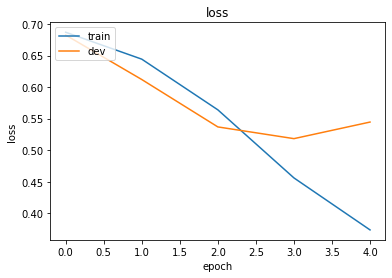

In [19]:
#@title Plot the learning curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
#@title Pre-trained embeddings (fromhttps://fasttext.cc/docs/en/crawl-vectors.html)

!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

import gzip

embeddings_index = {}
with gzip.open('cc.en.300.vec.gz', 'rt', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.strip().split()
        if len(values)<=2:
            continue
        word = " ".join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word.lower().strip()] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector



In [ ]:
#@title Classification with pre-trained embeddings (frozen)
model = Sequential()
model.add(Embedding(
    len(word_index)+1,
    300,
    weights=[embedding_matrix],
    trainable=False,
    input_shape=(50,)))
model.add(Bidirectional(GRU(8)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                    optimizer=opt,
                    metrics=['acc'])

cw = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train), 
    y=y_train)
cw = dict(enumerate(cw))
model.summary()
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=5,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_dev, y_dev),
                    class_weight=cw)
predictions = model.predict(X_test)
predicted_classes = [int(x>=0.5) for x in predictions]
print (classification_report(y_test, predicted_classes))


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
#@title Classification with pre-trained embeddings (continuing the training)
model = Sequential()
model.add(Embedding(
    len(word_index)+1,
    300,
    weights=[embedding_matrix],
    trainable=True,
    input_shape=(50,)))
model.add(Bidirectional(GRU(8)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                    optimizer=opt,
                    metrics=['acc'])
cw = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train), 
    y=y_train)
cw = dict(enumerate(cw))
model.summary()
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=5,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_dev, y_dev),
                    class_weight=cw)
predictions = model.predict(X_test)
predicted_classes = [int(x>=0.5) for x in predictions]
print (classification_report(y_test, predicted_classes))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
#@title Keras Functional API
from keras.layers import Input
from keras import Model

input = Input(shape=(50,))
emb = Embedding(
    len(word_index)+1,
    300,
    weights=[embedding_matrix],
    trainable=True,
    input_shape=(50,))(input)
gru = Bidirectional(GRU(8))(emb)
output = Dense(1, activation='sigmoid')(gru)

model = Model(inputs=input, outputs=output)

model.compile(loss='binary_crossentropy',
                    optimizer=opt,
                    metrics=['acc'])
cw = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train), 
    y=y_train)
cw = dict(enumerate(cw))
model.summary()
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=5,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_dev, y_dev),
                    class_weight=cw)
predictions = model.predict(X_test)
predicted_classes = [int(x>=0.5) for x in predictions]
print (classification_report(y_test, predicted_classes))